<header style="padding:1px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>Parkinson's Disease prediction using Feature Projection and Decision Tree Classifier</b>
</header>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Introduction</b></p>

<p style = 'font-size:16px;font-family:Arial'>Research shows that 89 percent of people with Parkinson’s disease (PD) experience speech and voice disorders, including soft, monotone, breathy and hoarse voice and uncertain articulation. As a result, people with PD report they are less likely to participate in conversation, or have confidence in social settings than healthy individuals in their age group.
<br>
Speech disorders can progressively diminish quality of life for a person with PD. The earlier a person receives a baseline speech evaluation and speech therapy, the more likely he or she will be able to maintain communication skills as the disease progresses. Communication is a key element in quality of life and positive self-concept and confidence for people with PD.
<br>
Hence as a consultant, we are approached by an organization to detect Parkinson's Disease at an early stage.</p>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Data</b></p>
<p style = 'font-size:16px;font-family:Arial'>This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Each column in the table is a particular voice measure, and each row corresponds one of 195 voice recording from these individuals ("name" column). The main aim of the data is to discriminate healthy people from those with PD, according to "status" column which is set to 0 for healthy and 1 for PD.</p>

<p style = 'font-size:16px;font-family:Arial'><a href = 'https://archive.ics.uci.edu/ml/datasets/parkinsons'>Link to the dataset</a>: Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008), 'Suitability of dysphonia measurements for telemonitoring of Parkinson's disease', IEEE Transactions on Biomedical Engineering (to appear).</p>

<p style = 'font-size:16px;font-family:Arial;color:#E37C4D'><b>Contents:</b></p>
<ol style = 'font-size:16px;font-family:Arial'>
    <li>Configuring the Environment</li>
    <li>Initiate a connection to Vantage</li>
    <li>Analyze the raw data set</li>
        <ul>
            <li>3.1 Inspect the data</li>
            <li>3.2 Derive the minimum viable number of features</li>
        </ul>
    <li>Reduce the number of features using Random Projection</li>
        <ul>
            <li>4.1 Create the matrix using TD_RandomProjectionFit</li>
            <li>4.2 Transform the Input Data</li>
        </ul>
    <li>Train and Test a Decision Tree Model</li>
        <ul>
            <li>5.1 Train and Test split using SAMPLE</li>
            <li>5.2 Train a Decision Tree Model</li>
            <li>5.3 Evaluate the Model</li>
        </ul>
    <li>Visualization</li>
    <li>Cleanup</li>
</ol>

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>1. Configuring the Environment</b>
<p style = 'font-size:16px;font-family:Arial'>In the section, we import the required libraries and set environment variables and environment paths (if required).</p>

In [71]:
import getpass
import pandas as pd
import seaborn as sns
from teradataml import *
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>2. Initiate a connection to Vantage</b>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>Make changes for your execution</b></p>

<p style = 'font-size:16px;font-family:Arial'>The Jupyter Module for Teradata provides a helper library called tdconnect - this can use the underlying client configs and pass a JWT token for SSO. Establish connection to Teradata Vantage server (uses the Teradata SQL Driver for Python). Before you execute the following statement, replace the variables &ltHOSTNAME&gt, &ltUID&gt and &ltPWD&gt with your target Vantage system hostname (or IP address), and your database user ID(QLID) and password, respectively.</p>
    
<p style = 'font-size:14px;font-family:Arial'>td_context = create_context(host="tdprdX.td.teradata.com", username="xy123456", password=gp.getpass(prompt='Password:'), logmech="LDAP")</p>

In [4]:
eng = create_context(host = 'host.docker.internal', username='demo_user', password = getpass.getpass())

 ········


<hr>
<p style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>3. Analyze the raw data set</b></p>

<p style = 'font-size:16px;font-family:Arial'>One of the challenges with this data set is that each recording consists of 755 individual metrics.  If this data set were to be used as input to a Decision Forest or other supervised learning algorithm "as is"; this large number of features would cause extraordinary performance degradation for very little gain in accuracy.  Not to mention, wrangling 755 columns adds additional complexity in programming and automation.</p>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>3.1 Inspect the data</b></p>
<p style = 'font-size:16px;font-family:Arial'>Simple SQL query to show the data - note the number of columns</p>

In [6]:
query = '''
SELECT * FROM pd_speech_features;
'''

pd.read_sql(query, eng)

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,469,1,0.10348,0.62955,0.58436,907,905,0.002107,0.001197,0.00082,...,19.954000,7.381100,4.884800,5.178400,5.044300,7.476000,8.231000,4.278500,11.853700,0
1,265,1,0.85117,0.79935,0.52510,193,192,0.009985,0.000081,0.00169,...,1.572500,1.619100,2.886500,5.473600,8.412300,10.747200,9.326000,6.003800,4.852400,1
2,734,0,0.80988,0.71329,0.42801,351,350,0.005489,0.000060,0.00108,...,7.331800,3.210100,4.008000,3.681700,3.037300,3.051900,2.769400,2.482800,2.889700,0
3,122,1,0.80080,0.67812,0.59670,230,229,0.008413,0.000076,0.00269,...,1.708200,2.894400,5.813600,4.872800,4.748000,7.586500,24.593901,28.867100,62.172100,1
4,61,0,0.82204,0.64209,0.49305,322,321,0.005992,0.000055,0.00136,...,1.565700,23.313299,14.626100,14.854000,10.255700,18.814699,52.290001,47.111099,93.709396,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,511,0,0.77436,0.66220,0.49417,327,326,0.005908,0.000072,0.00131,...,12.422900,9.115500,4.266600,4.909400,8.889200,8.731200,6.271200,8.303900,8.717900,1
752,551,1,0.84892,0.81018,0.40855,269,268,0.007166,0.000108,0.00246,...,2.785200,18.046600,63.987499,58.718601,54.465099,51.152599,55.785702,48.464298,93.652496,1
753,633,1,0.81476,0.65285,0.46147,213,212,0.009052,0.000041,0.00097,...,1.684300,9.701000,4.327800,4.033900,5.573000,4.678700,3.518000,4.112700,22.630800,0
754,143,1,0.70649,0.60081,0.50228,339,338,0.005697,0.000088,0.00174,...,149.876404,118.176498,105.658096,88.787102,56.569099,32.815300,20.303801,10.819800,3.863200,0


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>3.2 - Derive the minimum viable number of features</b></p>

<table style = 'width:100%;table-layout:fixed;'>
<tr>
    <td style = 'vertical-align:top' width = '50%'>
<p style = 'font-size:16px;font-family:Arial'>Random projection is a technique used to reduce the dimensionality of a set of points which lie in Euclidean space. The <b>TD_RandomProjectionsMinComponents</b> function uses a mathematical concept called <a href = 'https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma'>The Johnson-Lindenstrauss Lemma</a>, which is a technique for reducing the dimensionality of data with minimal distortion of the relationship between points. The lemma states that a set of points in a high-dimensional space can be embedded into a space of much lower dimension in such a way that distances between the points are nearly preserved. The function takes the following parameters:</p>
    <ul style = 'font-size:16px;font-family:Arial'>
        <li>An input Table, View, or Query</li>
        <li>Target Columns by name, position, or range.  Columns must be numeric</li>
        <li>Maximum Distortion (Epsilon) between 0 and 1, default of .1</li>
        </ul></td>
    <td><img src = 'images/J-L-l.png' width = '400'></td>
    </tr>
    </table>

<p style = 'font-size:16px;font-family:Arial'>The function returns the minimum number of columns required to meet the maximum distortion value.  Please see the <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Advanced-SQL-Engine-Analytic-Functions/April-2022/Feature-Engineering-Transform-Functions/TD_RandomProjectionMinComponents-Input'>Documentation</a> for full details.</p>
<table>
    <tr>
        <td><img src = 'images/sphx_glr_plot_johnson_lindenstrauss_bound_001.png' width = 400></td>
        <td><img src = 'images/sphx_glr_plot_johnson_lindenstrauss_bound_002.png' width = 400></td>
    </tr>
    </table>

In [9]:
query = '''
SELECT * FROM TD_RandomProjectionMinComponents (
ON pd_speech_features as InputTable
USING
TargetColumns('[1:753]')
Epsilon(0.4)
) as dt;
'''

pd.read_sql(query, eng)

,randomprojection_mincomponents
0,451


<p style = 'font-size:16px;font-family:Arial'>Here, the number minimum number of viable features as per <a href = 'https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma'>The Johnson-Lindenstrauss Lemma</a> is 451 with Maximum Distortion(Epsilon) of 0.4.</p>

<hr>
<p style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>4. Reduce the number of features using Random Projection</b></p>

<p style = 'font-size:16px;font-family:Arial'>Random Projection will apply a matrix of values to the input data which seeks to preserve pairwise distance between any two values in the data set.</p>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.1 - Create the matrix using TD_RandomProjectionFit</b></p>

<p style = 'font-size:16px;font-family:Arial'>This function takes the original data set as input, and outputs a permanent or volatile table containing the projection matrix. Additionally, the function takes the following parameters</p>
    <ul style = 'font-size:16px;font-family:Arial'>
        <li>A list or range of Columns</li>
        <li>Minimum component value</li>
        <li>Maximum Distortion (Epsilon) between 0 and 1, default of .1</li>
    <li>Optionally, a random seed value</li>
    <li>Projection Method</li>
    <li>Optional Sparse Density estimation (if using SPARSE projection)</li>
        </ul>
<p style = 'font-size:16px;font-family:Arial'>The function returns the matrix values.  Please see the <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Advanced-SQL-Engine-Analytic-Functions/April-2022/Feature-Engineering-Transform-Functions/TD_RandomProjectionFit'>Documentation</a> for full details.</p>

In [21]:
query = '''
SELECT * FROM TD_RandomProjectionFit(
ON pd_speech_features as InputTable
OUT VOLATILE TABLE OutputTable(pd_speech_features_rpfit)
USING
TargetColumns('[1:753]')
NumComponents(451) --Value we received from above
Seed(3005) --Random seed for repeatable results
Epsilon(0.4)
ProjectionMethod('GAUSSIAN')
--Density(.5)
) as dt;
'''

try:
    eng.execute(query)
except:
    eng.execute('DROP TABLE pd_speech_features_rpfit;')
    eng.execute(query)

pd.read_sql('SELECT * FROM pd_speech_features_rpfit;', eng)

,td_rpj_feature_451_0,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
0,0,0.051593,0.025707,0.040967,-0.006915,-0.007436,-0.012033,-0.059384,0.021332,0.040968,...,-0.021765,0.061699,0.022943,0.016450,0.006999,0.022979,0.114138,-0.028178,-0.039304,0.013730
1,1,0.006308,-0.036735,0.029968,-0.074778,-0.056662,-0.017461,0.005642,-0.064886,0.024349,...,0.056675,0.002158,0.061591,0.021410,0.030572,0.026153,-0.061582,0.026171,0.007632,0.012653
2,2,-0.023383,-0.025975,-0.054263,0.053360,-0.038905,-0.042956,-0.064253,0.049741,0.087575,...,-0.061153,-0.061263,0.043858,0.004762,0.016671,-0.032450,0.011126,0.041063,-0.067812,0.045095
3,3,0.031454,-0.024116,0.113476,0.035139,0.020629,-0.020700,-0.141088,-0.033135,0.095860,...,-0.017000,-0.017124,-0.000732,0.041132,0.018846,-0.049388,0.010449,-0.003593,-0.005634,-0.078594
4,4,-0.016746,0.017787,-0.000300,0.096484,0.012174,0.031673,0.049820,-0.036709,-0.072998,...,0.068053,-0.010052,0.013715,0.005767,-0.011999,-0.036731,-0.003566,-0.027904,0.037530,-0.011027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,446,-0.034969,-0.005619,-0.003556,0.016662,-0.053791,0.027883,-0.069023,-0.033857,-0.027936,...,-0.039619,-0.081381,0.012310,0.146092,-0.031469,0.004844,0.017604,-0.012435,0.159378,-0.002461
447,447,0.064723,-0.034698,0.096418,0.095361,0.043426,-0.088306,-0.024760,0.013346,0.013963,...,-0.036686,0.017316,-0.108405,0.009137,0.017933,0.092131,0.037027,-0.009836,0.014185,0.025653
448,448,0.041287,0.005097,-0.076810,0.011073,-0.083812,-0.026536,0.082050,-0.045670,-0.024256,...,-0.037251,0.032130,-0.031640,0.008345,-0.024523,-0.007262,0.004992,-0.021952,-0.021840,-0.007981
449,449,-0.012554,0.017100,-0.010452,-0.035805,-0.014730,-0.012869,0.085051,0.027254,0.025395,...,0.018394,0.000998,0.034353,0.049024,0.002666,0.000554,0.004048,0.012805,-0.065833,-0.053835


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>4.2 - Transform the Input Data</b></p>

<p style = 'font-size:16px;font-family:Arial'><b>TD_RandomProjectionTransform</b> takes the original data set and the matrix as inputs, and outputs the transformed data with reduced number of features.  Additionally, the function takes an "Accumulate" parameter to retain any columns (by name or range) from the original data set.  Please see the <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Advanced-SQL-Engine-Analytic-Functions/April-2022/Feature-Engineering-Transform-Functions/TD_RandomProjectionTransform'>Documentation</a> for full details.</p></p>
<br>

<p style = 'font-size:16px;font-family:Arial'>In this demonstration we return the results to a permanent table which will be used as inputs to the Decision Tree Classification process below</p> 

In [22]:
query = '''
create multiset table pd_speech_features_rp_transformed as (
    SELECT * FROM TD_RandomProjectionTransform(
        ON pd_speech_features as InputTable
        ON pd_speech_features_rpfit as FitTable DIMENSION
        USING
        Accumulate('id','"class"')) as dt
) with data;
'''

try:
    eng.execute(query)
except:
    eng.execute('DROP TABLE pd_speech_features_rp_transformed;')
    eng.execute(query)

pd.read_sql('SELECT * FROM pd_speech_features_rp_transformed;', eng)

,id,class,td_rpj_feature_0,td_rpj_feature_1,td_rpj_feature_2,td_rpj_feature_3,td_rpj_feature_4,td_rpj_feature_5,td_rpj_feature_6,td_rpj_feature_7,...,td_rpj_feature_441,td_rpj_feature_442,td_rpj_feature_443,td_rpj_feature_444,td_rpj_feature_445,td_rpj_feature_446,td_rpj_feature_447,td_rpj_feature_448,td_rpj_feature_449,td_rpj_feature_450
0,469,0,-3.332627e+09,1.707737e+09,5.892910e+07,-3.649881e+09,-2.243256e+09,-2.523973e+09,-3.095745e+09,1.046562e+09,...,4.055193e+09,6.850868e+09,-2.737748e+09,-4.457008e+07,-3.991274e+09,-4.647408e+09,-3.044948e+09,-2.928659e+08,3.088607e+07,-6.882641e+09
1,265,1,-1.364739e+08,6.967678e+07,1.589862e+06,-1.482063e+08,-8.959455e+07,-1.012761e+08,-1.258804e+08,4.237046e+07,...,1.654127e+08,2.778155e+08,-1.095980e+08,-3.380960e+06,-1.605504e+08,-1.873646e+08,-1.251094e+08,-9.977919e+06,2.046365e+06,-2.789703e+08
2,734,0,-4.974713e+08,2.545137e+08,6.545765e+06,-5.409670e+08,-3.278439e+08,-3.701838e+08,-4.581724e+08,1.540285e+08,...,6.019964e+08,1.013060e+09,-4.016708e+08,-9.266666e+06,-5.870666e+08,-6.848436e+08,-4.550800e+08,-3.863871e+07,6.374871e+06,-1.018197e+09
3,122,1,-1.924835e+08,9.831851e+07,2.320047e+06,-2.092388e+08,-1.267178e+08,-1.431126e+08,-1.776436e+08,5.981219e+07,...,2.333116e+08,3.921179e+08,-1.549733e+08,-4.415922e+06,-2.269276e+08,-2.647077e+08,-1.763398e+08,-1.443177e+07,2.659065e+06,-3.939092e+08
4,61,1,-4.027909e+08,2.059627e+08,5.215711e+06,-4.381439e+08,-2.656711e+08,-2.999076e+08,-3.713931e+08,1.249519e+08,...,4.877873e+08,8.206882e+08,-3.252686e+08,-7.863540e+06,-4.756482e+08,-5.547318e+08,-3.685787e+08,-3.119721e+07,5.124738e+06,-8.247846e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,511,1,-4.268281e+08,2.183444e+08,5.506057e+06,-4.640871e+08,-2.811484e+08,-3.174285e+08,-3.931503e+08,1.321479e+08,...,5.165530e+08,8.690780e+08,-3.443799e+08,-8.200402e+06,-5.035128e+08,-5.873758e+08,-3.905647e+08,-3.291241e+07,5.552825e+06,-8.734373e+08
752,551,1,-2.880686e+08,1.473130e+08,3.503527e+06,-3.129210e+08,-1.892226e+08,-2.138008e+08,-2.651621e+08,8.912638e+07,...,3.485694e+08,5.859054e+08,-2.317919e+08,-6.023626e+06,-3.390726e+08,-3.957266e+08,-2.637812e+08,-2.167645e+07,3.981850e+06,-5.888464e+08
753,633,0,-1.656728e+08,8.463419e+07,1.963972e+06,-1.800401e+08,-1.089876e+08,-1.230557e+08,-1.528898e+08,5.146997e+07,...,2.008300e+08,3.374405e+08,-1.332392e+08,-3.949001e+06,-1.951811e+08,-2.276734e+08,-1.518434e+08,-1.231038e+07,2.377782e+06,-3.389042e+08
754,143,0,-4.460643e+08,2.280997e+08,5.897070e+06,-4.852086e+08,-2.943803e+08,-3.322898e+08,-4.113682e+08,1.384718e+08,...,5.400960e+08,9.092037e+08,-3.605549e+08,-8.351129e+06,-5.271839e+08,-6.146505e+08,-4.080345e+08,-3.489294e+07,5.470513e+06,-9.137569e+08


<hr>
<p style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>5. Train and Test a Decision Tree Model</b></p>

<p style = 'font-size:16px;font-family:Arial'>Now that we have our prepared data set, we can perform an abbreviated machine learning workflow:</p>

<ol style = 'font-size:16px;font-family:Arial'>
    <li>Create Train and Test data sets using SAMPLE Clause</li>
    <li>Train the model</li>
    <li>Evaluate the model using Test data</li>
</ol>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>5.1 - Train and Test split using SAMPLE</b></p>

<p style = 'font-size:16px;font-family:Arial'>Using EXCEPT clause in the second statement ensures a non-intersecting set of data</p>

In [29]:
query = '''
CREATE MULTISET TABLE pd_speech_features_rp_transformed_train AS (
    SELECT * FROM pd_speech_features_rp_transformed SAMPLE 0.8
) WITH DATA
PRIMARY INDEX(id)
'''

try:
    eng.execute(query)
except:
    eng.execute('DROP TABLE pd_speech_features_rp_transformed_train;')
    eng.execute(query)

train = pd.read_sql('SELECT * FROM pd_speech_features_rp_transformed_train', eng)
pd.read_sql('SELECT "class", COUNT(*) FROM pd_speech_features_rp_transformed_train GROUP BY "class"', eng)

,class,Count(*)
0,1,459
1,0,146


In [30]:
query = '''
CREATE MULTISET TABLE pd_speech_features_rp_transformed_test AS (
    SELECT * FROM pd_speech_features_rp_transformed
    EXCEPT
    SELECT * FROM pd_speech_features_rp_transformed_train
) WITH DATA
PRIMARY INDEX(id)
'''

try:
    eng.execute(query)
except:
    eng.execute('DROP TABLE pd_speech_features_rp_transformed_test;')
    eng.execute(query)

test = pd.read_sql('SELECT * FROM pd_speech_features_rp_transformed_test', eng)
pd.read_sql('SELECT "class", COUNT(*) FROM pd_speech_features_rp_transformed_test GROUP BY "class"', eng)

,class,Count(*)
0,1,105
1,0,46


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>5.2 - Train a Decision Tree Model</b></p>

In [59]:
clf = DecisionTreeClassifier(random_state=42, max_depth = 5)
model = clf.fit(train.iloc[:, 2:], train["class"])

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'><b>5.3 - Evaluate the Model</b></p>

In [60]:
pred = model.predict(test.iloc[:, 2:])

In [62]:
pd.DataFrame(confusion_matrix(np.array(test["class"]), pred))

,0,1
0,10,36
1,12,93


In [88]:
print("Accuracy of the model:", round(accuracy_score(np.array(test["class"]), pred), 4)*100, "%")

Accuracy of the model: 68.21000000000001 %


<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>6. Visualization</b>

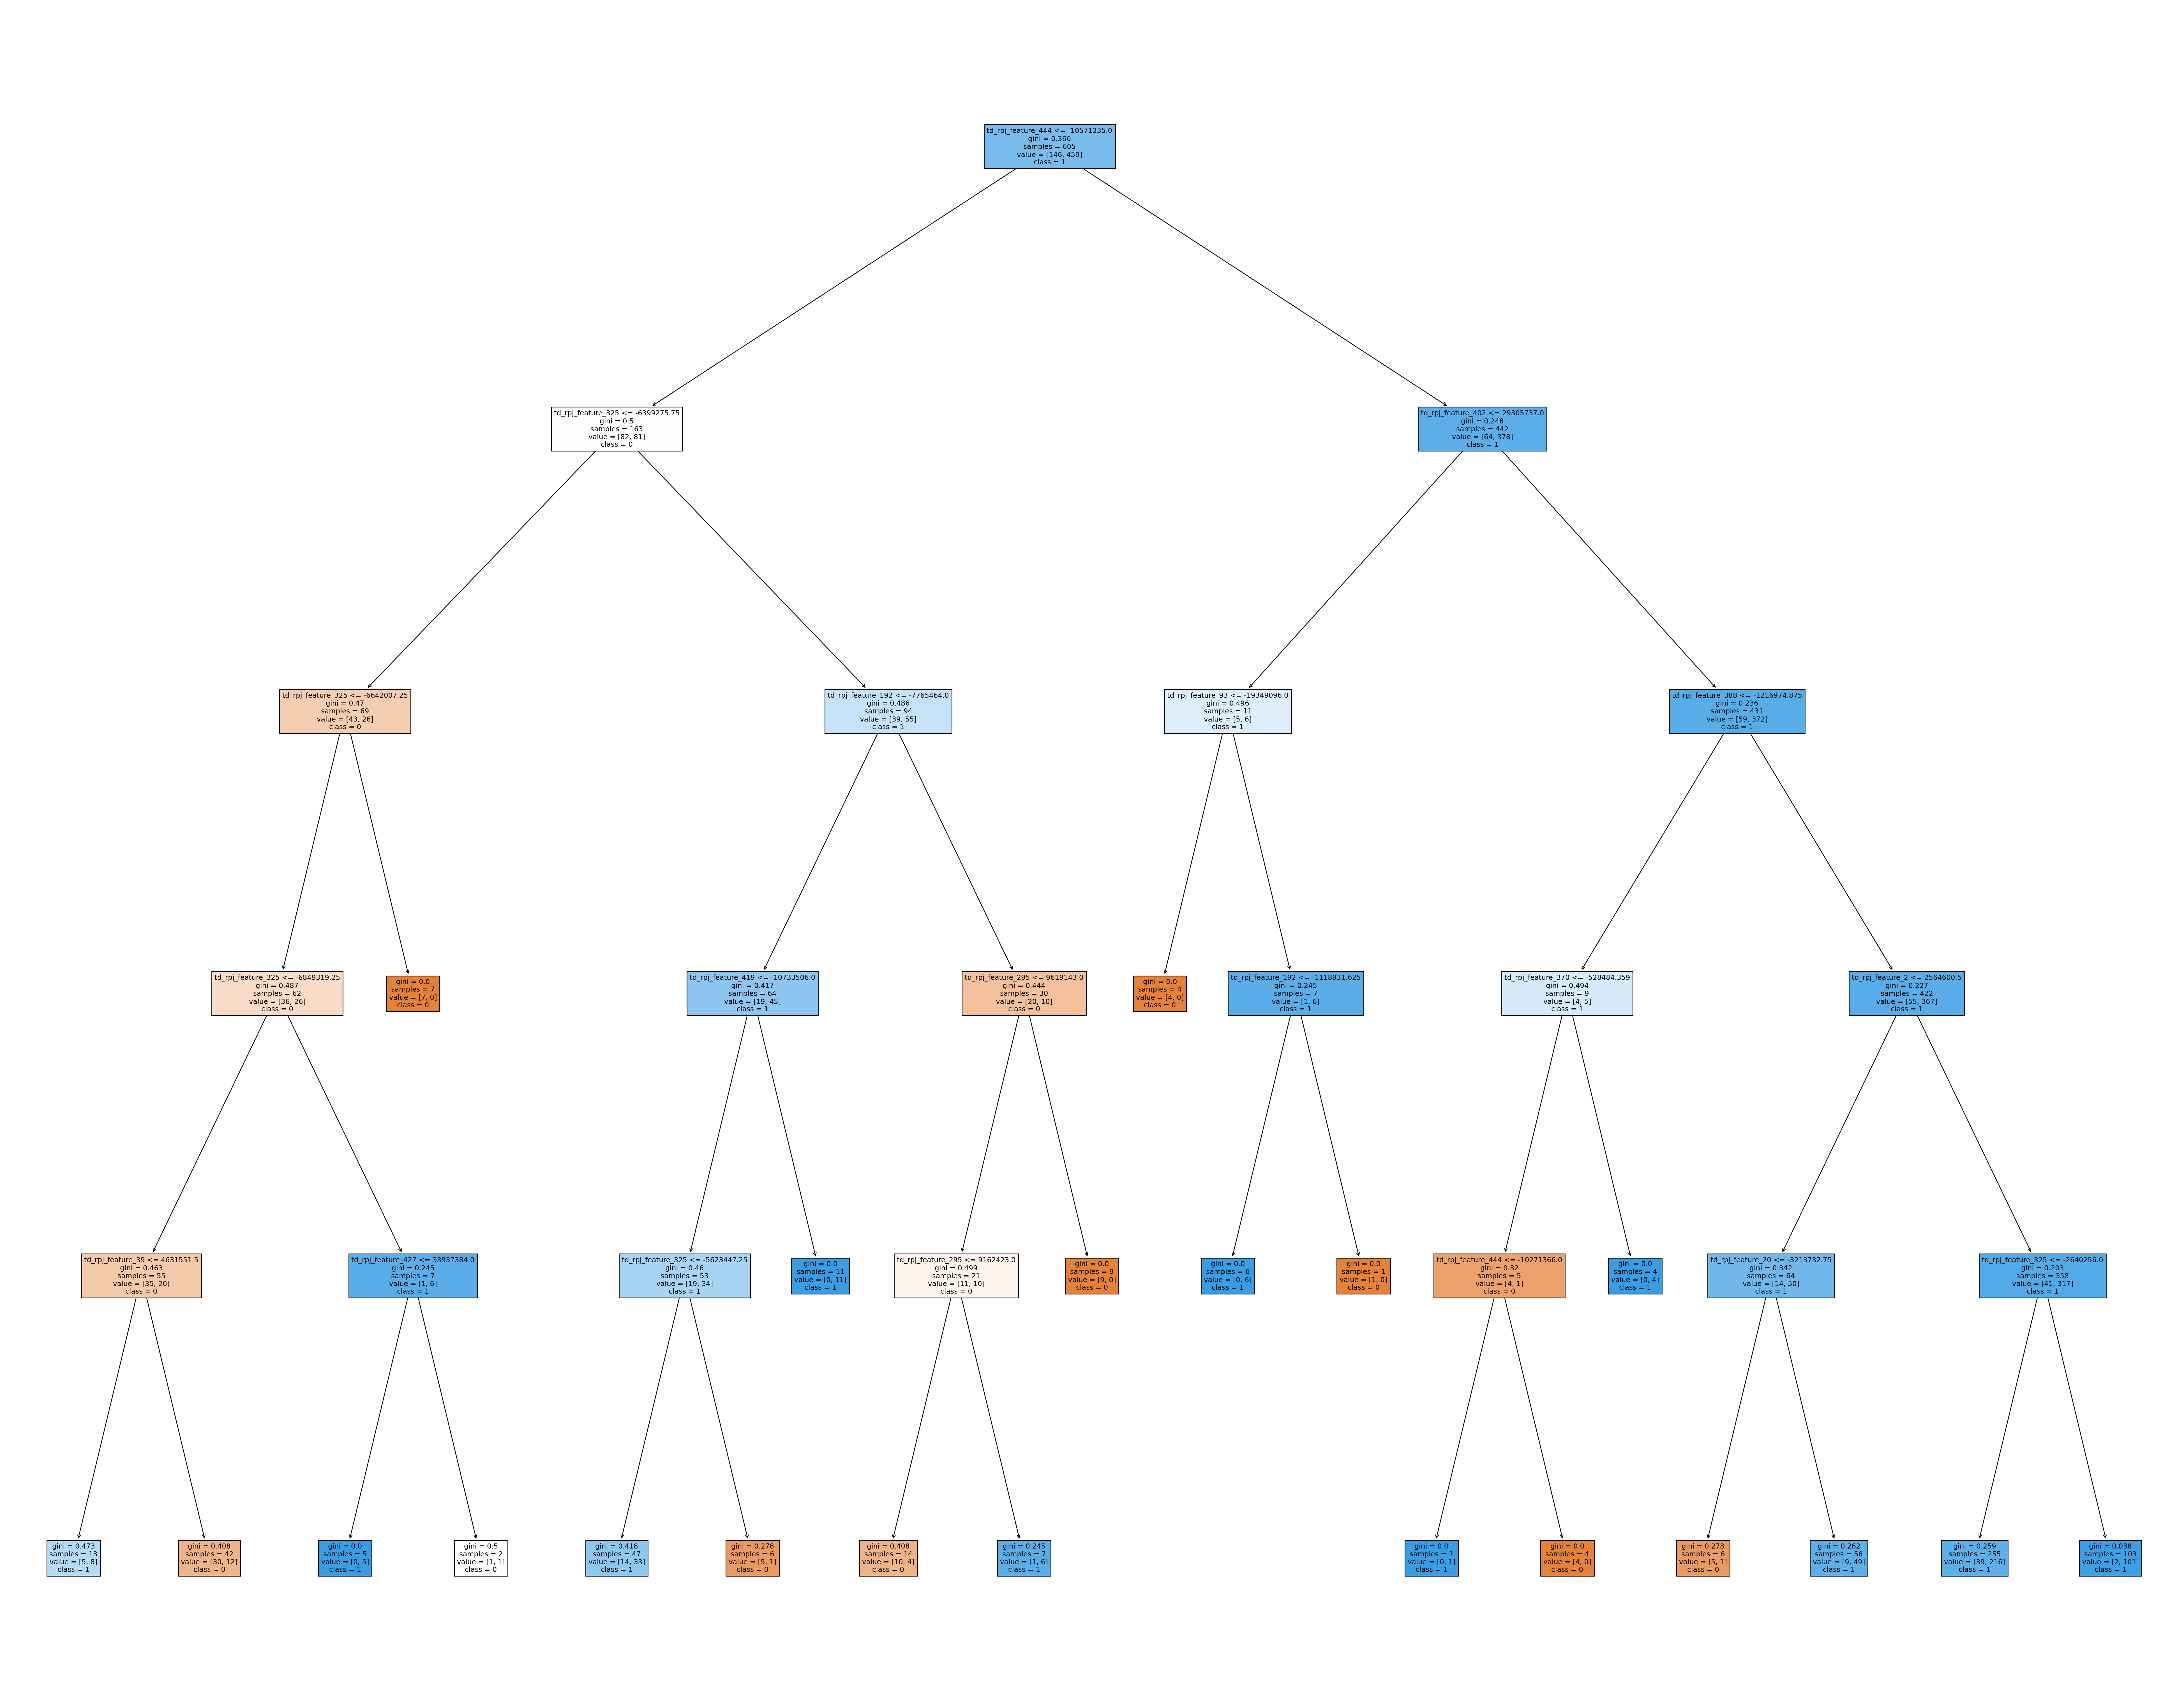

In [64]:
fig = plt.figure(figsize=(50,40), dpi = 200)
_ = tree.plot_tree(clf, 
                   feature_names=train.columns[2:],
                   class_names=['0', '1'],
                   filled=True)

In [65]:
fig.savefig("viz.png", dpi = 200)

In [68]:
feature_imp = pd.Series(clf.feature_importances_,index=train.iloc[:, 2:].columns).sort_values(ascending=False)

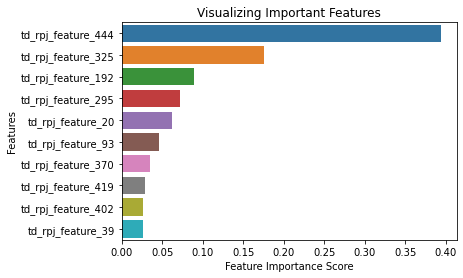

In [75]:
sns.barplot(x=feature_imp[:10], y=feature_imp[:10].index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

<hr>
<b style = 'font-size:28px;font-family:Arial;color:#E37C4D'>7. Cleanup</b>

In [78]:
eng.execute('DROP TABLE pd_speech_features_rpfit;')

In [79]:
eng.execute('DROP TABLE pd_speech_features_rp_transformed;')

In [80]:
eng.execute('DROP TABLE pd_speech_features_rp_transformed_train;')

In [81]:
eng.execute('DROP TABLE pd_speech_features_rp_transformed_test;')

<footer style="padding:10px;background:#f9f9f9;border-bottom:3px solid #394851">©2022 Teradata. All Rights Reserved</footer>